# **Import Module**

In [1]:
78pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K 
from tensorflow.python.keras.layers import Layer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ultimatrix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Import Data**

The code snippet sets up the environment to load a CSV file containing news summaries into a pandas DataFrame and displays the first few rows to inspect the data.

In [7]:
##Specifying the Path to the Dataset
data_path = 'data/news_summary_more.csv'

#Loading the Dataset
data = pd.read_csv(data_path)

#Displaying the First Few Rows
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [9]:
#Removing Duplicates
data.drop_duplicates(subset=['headlines'],inplace=True)

#Resetting the Index
data.reset_index(inplace=True, drop=True)

# **Data Preprocessing**

The preprocess function performs several steps to clean and standardize text data:
* Converts text to lowercase.
* Expands contractions.
* Removes stop words.
* Removes possessive 's and periods.
* Removes text within parentheses.
* Replaces non-alphanumeric characters (except periods and spaces) with spaces.
* Ensures spaces follow periods.
* Replaces multiple spaces with a single space.

In [13]:
#Loading Stop Words
stop_words = stopwords.words('english')

#Defining the preprocess Function
def preprocess(text):
    
    #Converting Text to Lowercase
    text = text.lower()
    
    #Expanding Contractions
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    #Removing Stop Words
    tokens = [w for w in text.split() if not w in stop_words]
    
    #Additional Text Cleaning
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    
    #Returning the Cleaned Text
    return text

The code preprocesses the text data in both the 'headlines' and 'text' columns, adds special tokens to the 'headlines', and prints the first two examples.
* **Preprocessing Columns**: Both the 'headlines' and 'text' columns are preprocessed to clean and standardize the text using the preprocess function defined earlier. This ensures that the text is in a consistent format, which is crucial for tasks like text summarization or machine learning.
* **Adding Tokens**: The start (_START_) and end (_END_) tokens are added to the 'headlines' to indicate the beginning and end of the summary. This is often done in sequence-to-sequence models, such as those used in text generation or summarization, to help the model understand where the summary starts and ends.
* **Printing Examples**: Printing the first two processed entries allows for a quick inspection to ensure that the preprocessing steps have been applied correctly and to see examples of the formatted text and summaries.

In [16]:
#Preprocessing the 'headlines' Column
data['headlines'] = data['headlines'].apply(preprocess)

#Preprocessing the 'text' Column
data['text'] = data['text'].apply(preprocess)

#Adding Start and End Tokens to 'headlines'
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

#Printing Processed Examples
for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ upgrad learner switches career ml al 90 salary hike _END_
Text:
saurav kant alumnus upgrad iiit b pg program machine learning artificial intelligence sr systems engineer infosys almost 5 years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered 3 lakh careers

Summary:
_START_ delhi techie wins free food swiggy one year cred _END_
Text:
kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cultfit more



The provided lines of code generate two lists: headlines_length and text_length. Each element in these lists represents the number of words in a corresponding entry in the 'headlines' and 'text' columns, respectively.

In [19]:
#Calculating the Lengths of 'headlines'
headlines_length = [len(x.split()) for x in data.headlines]

#Calculating the Lengths of 'text'
text_length = [len(x.split()) for x in data.text]

The code below creates a figure with two side-by-side histograms to visualize the distribution of word counts in the 'headlines' and 'text' columns of the DataFrame.

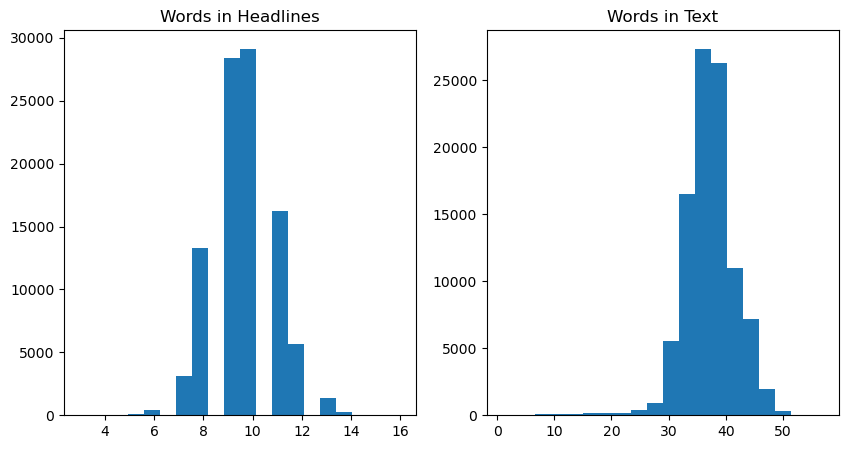

In [22]:
#Creating a Figure and Subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

#Plotting Histograms
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

#Setting Titles for Subplots
ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")

#Displaying the Plot
plt.show()

# **Embedding Matrix**

The code below sets up for using GloVe embeddings by specifying the embedding size (300 dimensions) and opening the GloVe embeddings file.

In [26]:
#Setting the Embedding Size
glove_size = 300

#Opening the GloVe Embeddings File
f = open('data/glove.42B.300d.txt')

The code snippet below reads the pre-trained GloVe word embeddings from a file and stores them in a dictionary called embeddings_index. Each word in the dictionary is associated with its corresponding 300-dimensional word vector

In [29]:
#Creating an Empty Dictionary for Embeddings
embeddings_index = dict()

#Iterating Over Each Line in the File
for line in f:
    
    #Processing Each Line
    values = line.split()
    
    #Storing the Word and Its Embedding in the Dictionary
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    
#Closing the File
f.close()

The code snippet processes the text data to:
* Collect all words and unique words in the corpus.
* Compare the unique words with the GloVe vocabulary to determine how many words have corresponding GloVe vectors.
* Create a dictionary of word vectors for the words in the corpus that have corresponding GloVe vectors.

In [32]:
#Collecting All Words in the Corpus
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

#Printing the Total Number of Words in the Corpus
print("all the words in the corpus", len(words_source_train))

#Identifying Unique Words in the Corpus
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))

#Finding Intersection with GloVe Vocabulary
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

#Creating a Dictionary of Word Vectors for the Corpus
words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 3664472
the unique words in the corpus 89937
The number of words that are present in both glove vectors and our corpus are 70870 which is nearly 79.0% 
word 2 vec length 70870


For the code cell below:
* **Purpose**: This line of code identifies and prints a sample of words from the corpus that do not have corresponding GloVe vectors. This can help us understand which words in our corpus are missing from the pre-trained embeddings and may need to be handled separately (e.g., by using random vectors, learning embeddings from scratch, or ignoring them).
* **Use Case**: This is useful for diagnosing coverage issues with the embeddings and understanding the extent to which our corpus differs from the vocabulary covered by the GloVe embeddings.

In [35]:
#Finding and Printing Words Not in GloVe
print(list(words_source_train - inter_words)[:20])

['', 'fartjacker', 'shrivallabh', 'butrada', 'bagalagunte', 'kurangani', 'timiyah', 'mahayagya', 'gaalis', 'panjgraian', 'kumam', 'mintoo', 'deliverycom', 'matterotherwise', 'spendingtime', 'mawmluh', 'borderseven', 'gandelsman', 'undertakesbut', 'pearlside']


The code defines a function to count words in each text entry of a DataFrame that are not present in a predefined set of words with GloVe vectors. This count is then added as a new column in the DataFrame, allowing for analysis of the extent to which words in the text are missing from the GloVe embeddings.

In [38]:
#Defining the Function num
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

#Applying the Function to the DataFrame
data['unique_words'] = data['text'].apply(num)

The **value_counts**() method on the 'unique_words' column provides a count of how many entries have each unique number of words that are missing from the GloVe embeddings.

In [41]:
data['unique_words'].value_counts()

unique_words
0    73902
1    15827
2     5772
3     1973
4      559
5      173
6       59
7       11
8        4
Name: count, dtype: int64

The code snippet filters the DataFrame data to retain only those rows where the number of unique words not present in GloVe embeddings is less than 4. It then resets the index of the DataFrame to ensure that it is sequential and free from gaps.

In [44]:
#Filtering Rows
data = data[data['unique_words'] < 4]

#Resetting the Index
data.reset_index(inplace=True, drop=True)

In [46]:
data

,headlines,text,unique_words
0,_START_ upgrad learner switches career ml al 9...,saurav kant alumnus upgrad iiit b pg program m...,0
1,_START_ delhi techie wins free food swiggy one...,kunal shah credit card bill payment platform c...,2
2,_START_ new zealand end rohit sharma led india...,new zealand defeated india 8 wickets fourth od...,0
3,_START_ aegon life iterm insurance plan helps ...,aegon life iterm insurance plan customers enjo...,0
4,_START_ known hirani yrs metoo claims true son...,speaking sexual harassment allegations rajkuma...,0
...,...,...,...
97469,_START_ crpf jawan axed death maoists chhattis...,crpf jawan tuesday axed death sharp edged weap...,0
97470,_START_ first song sonakshi sinha noor titled ...,uff yeh first song sonakshi sinha starrer upc...,2
97471,_START_ the matrix film get reboot reports _END_,according reports new version 1999 science fic...,0
97472,_START_ snoop dogg aims gun clown dressed trum...,new music video shows rapper snoop dogg aiming...,0


# **Train Test Split**

The code performs two sequential splits on the dataset to create three subsets:
* **Training Set (X_train, y_train)**: 80% of the data used to train the model.
* **Validation Set (X_val, y_val)**: 10% of the data used to tune model parameters and avoid overfitting.
* **Test Set (X_test, y_test)**: 10% of the data used to evaluate the final model's performance.

In [50]:
from sklearn.model_selection import train_test_split

#First Split: Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)

#Second Split: Validation and Test Sets
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

The lines of code in the cell below calculate and store the lengths of the longest text and headline in the dataset. The maximum lengths are essential for preparing the data for machine learning models, ensuring that all sequences are of a consistent size by padding or truncating them accordingly.

In [53]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

The process in the cell below transforms raw text data into a format that can be used by machine learning models, ensuring that all input sequences have a consistent size and are represented as integer indices.
* **Tokenizer Initialization and Fitting**: The Tokenizer is used to create a vocabulary from all the texts and headlines, mapping each word to a unique integer.
* **Vocabulary Size**: The vocabulary size is determined and adjusted to include an index for padding.
* **Text to Sequences**: Texts are converted to sequences of integers based on the vocabulary.
* **Padding Sequences**: Sequences are padded to ensure they all have the same length, making them suitable for input into neural network models.

In [56]:
#Creating and Fitting the Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])

#Getting Vocabulary Size
x_vocab_size = len(x_t.word_index) + 1

#Encoding Texts into Sequences
encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

#Padding Sequences
padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [57]:
#Creating and Fitting the Tokenizer
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])

#Getting Vocabulary Size
y_vocab_size = len(y_t.word_index) + 1
    
#Encoding Texts into Sequences
encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

#Padding Sequences
padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

The embedding matrix will be used in our model to provide pre-trained word vectors as input, improving the model's ability to understand and process text based on GloVe's semantic embeddings.
* **Loaded Word Vectors**: The number of word vectors loaded from GloVe is printed to verify successful loading.
* **Embedding Matrix Initialization**: A matrix is created to hold the word embeddings for the vocabulary. This matrix will be used in the model to represent words with their GloVe vectors.
* **Matrix Population**: The embedding matrix is populated with GloVe vectors for words that exist in the vocabulary. Words not found in GloVe remain as zeros, which are usually handled by the model during training.

In [61]:
#Printing the Count of Loaded Vectors
print('Loaded %s word vectors.' % len(embeddings_index))

#Initializing the Embedding Matrix
embedding_matrix = np.zeros((x_vocab_size, glove_size))

#Populating the Embedding Matrix
for word, i in x_t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


# **Model Creation**

The AttentionLayer implements a custom attention mechanism using a specific architecture:
* **Weights**: W_a, U_a, and V_a are used for computing attention scores.
* **Attention Computation**: The energy_step function calculates attention scores, and the context_step function computes the context vectors.
* **Initial States**: Dummy initial states are created for the RNN computations.
* **RNN Operations**: The attention mechanism is applied using K.rnn to calculate attention scores and context vectors.
* **Output Shapes**: The output shapes are defined for the context vectors and attention scores.

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[0][2], 1),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def create_initial_state(self, inputs, hidden_size):
        """
        Create an initial state tensor for attention.
        This version ensures compatibility with symbolic tensors.
        """
        batch_size = tf.shape(inputs)[0]  # Dynamically determine batch size
        fake_state = tf.zeros([batch_size, hidden_size], dtype=inputs.dtype)
        return fake_state

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
            en_seq_len, en_hidden = tf.shape(encoder_out_seq)[1], tf.shape(encoder_out_seq)[2]
            de_hidden = tf.shape(inputs)[-1]

            reshaped_enc_outputs = tf.reshape(encoder_out_seq, [-1, en_hidden])
            W_a_dot_s = tf.reshape(tf.matmul(reshaped_enc_outputs, self.W_a), [-1, en_seq_len, en_hidden])
            U_a_dot_h = tf.expand_dims(tf.matmul(inputs, self.U_a), 1)

            reshaped_Ws_plus_Uh = tf.nn.tanh(W_a_dot_s + U_a_dot_h)
            e_i = tf.nn.softmax(tf.reshape(tf.matmul(reshaped_Ws_plus_Uh, self.V_a), [-1, en_seq_len]), axis=-1)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = tf.reduce_sum(encoder_out_seq * tf.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        # Create initial states
        fake_state_c = self.create_initial_state(encoder_out_seq, tf.shape(encoder_out_seq)[-1])
        fake_state_e = self.create_initial_state(encoder_out_seq, tf.shape(encoder_out_seq)[1])

        # Ensure RNN layers are properly used
        last_out, e_outputs, _ = tf.compat.v1.keras.backend.rnn(
            energy_step, decoder_out_seq, [fake_state_e]
        )

        last_out, c_outputs, _ = tf.compat.v1.keras.backend.rnn(
            context_step, e_outputs, [fake_state_c]
        )
        
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


The code constructs a sequence-to-sequence model with an attention mechanism:
* **Encoder**: Uses a stack of LSTM layers to process the input sequence.
* **Decoder**: Uses an LSTM layer initialized with the encoder's final states to generate output sequences.
* **Attention Mechanism**: Enhances the decoder by focusing on relevant parts of the encoder's output.
* **Final Layer**: Applies a dense layer to predict the next token in the sequence at each time step.

In [68]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 57, 300)   │ 27,025,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 57, 500), │  1,602,000 │ embedding[0][0]   │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 57, 500), │  2,002,000 │ lstm[0][0]        │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │ 27,025,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 57, 500), │  2,002,000 │ lstm_1[0][0]      │
│                     │ (None, 500),      │            │                   │
│                     │ (None, 500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  1,602,000 │ embedding_1[0][0… │
│                     │ 500), (None,      │            │ lstm_2[0][1],     │
│                     │ 500), (None,      │            │ lstm_2[0][2]      │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    500,500 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 500), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 57)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │ 1000)             │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 34,831,797 │ concat_layer[0][… │
│ (TimeDistributed)   │ 34797)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 96,590,697 (368.46 MB)

 Trainable params: 42,540,297 (162.28 MB)

 Non-trainable params: 54,050,400 (206.19 MB)

None




# **Training**

The setup ensures efficient training by saving the best model and preventing overfitting through early stopping.
* **Compiling**: Configures the model for training with the Adam optimizer and sparse categorical crossentropy loss.
* **Callbacks**: Includes model checkpointing to save the best model and early stopping to halt training if validation loss does not improve.
* **Training**: Trains the model for 10 epochs with a batch size of 512, using both training and validation data, and applying the specified callbacks.

In [72]:
#Model Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

#Model Checkpoint
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True, 
                                                               save_freq = "epoch")

#Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
#Model Training
history=model.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,
                  epochs=10,
                  batch_size=512, 
                  validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), 
                  callbacks=[es, model_checkpoint_callback])

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


153/153 ━━━━━━━━━━━━━━━━━━━━ 2754s 18s/step - loss: 5.4832 - val_loss: 4.4701
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5575s 37s/step - loss: 4.3956 - val_loss: 4.1319
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 3425s 22s/step - loss: 3.9359 - val_loss: 3.7470
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2354s 15s/step - loss: 3.4633 - val_loss: 3.5160
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2308s 15s/step - loss: 3.0782 - val_loss: 3.3644
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2213s 14s/step - loss: 2.7217 - val_loss: 3.2804
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2181s 14s/step - loss: 2.4266 - val_loss: 3.2289
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2361s 15s/step - loss: 2.1866 - val_loss: 3.1934
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2288s 15s/step - loss: 1.9778 - val_loss: 3.1806
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2254s 15s/step - loss: 1.8122 - val_loss: 3.1820
Epoch 10: early stopping


In [76]:
import os
import re

def find_best_model_file(directory, pattern="model.*.weights.h5"):
    files = os.listdir(directory)
    best_loss = float('inf')
    best_model_file = None
    for file in files:
        # Updated regex to correctly parse the loss value in the filename
        match = re.search(r'-([\d]+\.[\d]+)\.weights\.h5$', file)
        if match:
            val_loss = float(match.group(1))  # Extract the loss value
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_file = file
    
    return os.path.join(directory, best_model_file) if best_model_file else None

# Load the best model weights
best_model_filepath = find_best_model_file('./')
if best_model_filepath:
    model.load_weights(best_model_filepath)
    print(f"Loaded weights from {best_model_filepath}")
else:
    print("No model file found.")


Loaded weights from ./model.01-3.15.weights.h5


In [78]:
loss = model.evaluate([padded_xval, padded_yval[:, :-1]], padded_yval.reshape(padded_yval.shape[0], padded_yval.shape[1], 1)[:, 1:])
print(f"Validation loss after loading best weights: {loss}")

305/305 ━━━━━━━━━━━━━━━━━━━━ 106s 348ms/step - loss: 3.1483
Validation loss after loading best weights: 3.1473400592803955


The snippet of code is used to load a previously saved model's weights and recompile it. 
* **Reconstructing the Model**: Recreates the model architecture to match the one used during training. This step is crucial because the model needs to have the same structure to correctly load the weights.
* **Loading Weights**: Loads the weights from a specific file into the reconstructed model. This allows us to use the trained model’s parameters without retraining.
* **Recompiling**: Sets up the model with the same optimizer and loss function used during training, preparing it for evaluation or further training.

In [80]:
#Reconstructing the Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Loading Weights
model.load_weights("./model.01-3.15.weights.h5")

#Recompiling the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

This code creates a plot showing how the training and validation loss change over epochs. This visualization helps in understanding the model's performance during training:
* **Training Loss (train)**: Indicates how well the model is fitting the training data.
* **Validation Loss (test)**: Indicates how well the model is generalizing to unseen data.

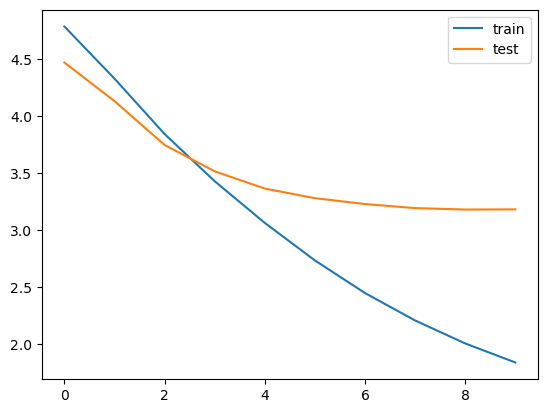

In [84]:
from matplotlib import pyplot 

#Plotting Training and Validation Loss
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

# **Inference**

The mappings below are crucial for tasks such as converting model predictions back into readable words or for analyzing and interpreting the model’s output.
* **reverse_target_word_index**: Maps indices to words for the target vocabulary.
* **reverse_source_word_index**: Maps indices to words for the source vocabulary.
* **target_word_index**: Maps words to indices for the target vocabulary.

In [88]:
#Reverse Target Word Index
reverse_target_word_index = y_t.index_word 

#Reverse Source Word Index
reverse_source_word_index = x_t.index_word 

#Target Word Index
target_word_index = y_t.word_index

These models are used together for generating sequences during inference. The encoder processes the input sequence, and the decoder generates the output sequence step-by-step, using the attention mechanism to focus on relevant parts of the input sequence.

In [91]:
#Encoder Model
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder Model
#Defining Input Layers for Decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

#Decoder Embedding and LSTM
dec_emb2= dec_emb_layer(decoder_inputs)

#Concatenate and Dense Layer
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention Mechanism
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

#Concatenate and Dense Layer
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_dense(decoder_inf_concat)

#Define Decoder Model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

The function below is typically used for generating predictions
* **Encoding**: The input sequence is processed by the encoder to obtain the encoder outputs and states.
* **Decoding**: The decoder generates the sequence one token at a time using the attention mechanism and updated states.
* **Termination**: The loop continues until an end token is generated or the sentence reaches the maximum length.

In [94]:
#Function Definition
def decode_sequence(input_seq):
    
    #Preprocessing Input Sequence
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #Initialization
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    #Decoding Loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    #Return Decoded Sentence
    return decoded_sentence

Both functions below are useful for interpreting model outputs and inputs by translating numerical representations back into human-readable form.
* **seq2summary**: Converts a target sequence from indices to a readable summary text, excluding special tokens like start and end tokens.
* **seq2text**: Converts a source sequence from indices to a readable text, excluding padding tokens.

In [97]:
#Function: seq2summary
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

#Function: seq2text
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

The code snippet below evaluates the performance of the sequence-to-sequence model by comparing the original summaries with the predicted summaries for a sample of test data

In [100]:
for i in range(10):
  print("Review:",seq2text(padded_xtest[i]))
  print("Original summary:",seq2summary(padded_ytest[i]))
  print("Predicted summary:",decode_sequence(padded_xtest[i]))
  print("\n")

Review: former lieutenant governor najeeb jung disapproved delhi government proposed premium bus scheme last year government monday announced plans app based bus service project least 1 000 buses run private operators service aims reduce use private vehicles state transport minister kailash gahlot said 
Original summary: delhi government plans app based bus service 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_11', 'keras_tensor_22', 'keras_tensor_20', 'keras_tensor_21']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted summary:  former finance minister finance service metro service


Review: slamming odisha bjd government suicide girl claimed raped four men uniform congress bjp called separate demonstrations state wide shutdown thursday elaborate safety arrangements made police schools colleges state remain shut safety students 
Original summary: cong bjp call odisha bandh rape victim suicide 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


# **Evaluation**

The **BLEU_Score** function is designed to evaluate the quality of machine-generated summaries by calculating the **BLEU** (Bilingual Evaluation Understudy) score. BLEU is a metric for evaluating the quality of text generated by a model compared to reference texts.

In [127]:
from fractions import Fraction
from collections import Counter
from nltk.util import ngrams
from nltk.translate.bleu_score import SmoothingFunction

def custom_modified_precision(references, hypothesis, n):
    """
    Custom implementation of modified n-gram precision for BLEU.
    """
    # Generate n-grams for the hypothesis
    hypothesis_ngrams = Counter(ngrams(hypothesis, n))

    # Generate n-grams for each reference
    max_reference_ngrams = Counter()
    for reference in references:
        reference_ngrams = Counter(ngrams(reference, n))
        for ngram in reference_ngrams:
            max_reference_ngrams[ngram] = max(max_reference_ngrams[ngram], reference_ngrams[ngram])

    # Calculate clipped n-gram counts
    clipped_counts = {
        ngram: min(count, max_reference_ngrams[ngram])
        for ngram, count in hypothesis_ngrams.items()
    }

    # Numerator and denominator for modified precision
    numerator = sum(clipped_counts.values())
    denominator = max(1, sum(hypothesis_ngrams.values()))

    # Return fraction
    return Fraction(numerator, denominator)

def custom_corpus_bleu(list_of_references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25)):
    """
    Custom corpus BLEU implementation to avoid `_normalize` issues.
    """
    p_numerators = Counter()
    p_denominators = Counter()

    # Compute n-gram precisions
    for references, hypothesis in zip(list_of_references, hypotheses):
        for i in range(1, len(weights) + 1):
            p_i = custom_modified_precision(references, hypothesis, i)
            p_numerators[i] += p_i.numerator
            p_denominators[i] += p_i.denominator

    # Calculate geometric mean of precisions
    p_n = [
        (p_numerators[i] / p_denominators[i]) if p_denominators[i] > 0 else 0
        for i in range(1, len(weights) + 1)
    ]
    geometric_mean = (
        (p_n[0] ** weights[0]) * (p_n[1] ** weights[1]) * (p_n[2] ** weights[2]) * (p_n[3] ** weights[3])
    )

    # Apply brevity penalty
    hypothesis_length = sum(len(hypothesis) for hypothesis in hypotheses)
    reference_length = sum(len(min(refs, key=len)) for refs in list_of_references)
    brevity_penalty = (
        1 if hypothesis_length > reference_length else (hypothesis_length / reference_length) ** 0.5
    )

    return brevity_penalty * geometric_mean



In [129]:
#Function Definition
def BLEU_Score(y_test, y_pred):
    
    #Convert Target Summary (y_test) to Readable Text:
    references = [[seq2summary(y_test).split(" ")]]
    
    #Convert Predicted Summary (y_pred) to Readable Text:
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    
    #Compute BLEU Score:
    return custom_corpus_bleu(references, candidates)

The code snippet calculates and prints the average BLEU score for the first 500 test samples

In [132]:
from nltk.translate.bleu_score import corpus_bleu

#Initialize an Empty List:
scores=[]

#Loop Through First 500 Test Samples:
for i in range(0,50):
    
    #Calculate BLEU Score for Each Sample:
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
#Calculate and Print the Average BLEU Score:
print(np.mean(scores))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

The Universal Sentence Encoder is designed to provide embeddings for sentences
* **Purpose**: To load a pre-trained Universal Sentence Encoder model from TensorFlow Hub, which can be used to convert sentences into vector embeddings for various natural language processing tasks.
* **Inputs**: The URL of the pre-trained model.
* **Outputs**: A confirmation message that the model has been successfully loaded and is ready for use.

In [170]:

import tensorflow_hub as hub
from scipy import spatial

#Define the URL for the Model:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

#Load the Model from TensorFlow Hub:
sentence_encoder = hub.load(module_url)

#Print Confirmation Message:
print ("module %s loaded" % module_url)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


The cosine similarity score provides a way to evaluate how closely the generated summaries match the actual summaries in terms of their semantic content.

In [172]:
#Function Definition
def cosine_similarity(padded_xval, padded_yval):
    
    #Initialize an Empty List for Scores:
    scores = []
    for i in range(len(padded_xval)):
        
        #Convert Token Sequences to Text:
        str1 = seq2summary(padded_yval[i])
        str2 = decode_sequence(padded_xval[i])
        
        #Get Sentence Embeddings:
        embeddings = sentence_encoder([str1, str2]).numpy()
        
        #Compute Cosine Similarity:
        result = 1 - spatial.distance.cosine(embeddings[0], embeddings[1])
        
        #Append the Similarity Score:
        scores.append(result)
        
    #Return the List of Scores:
    return scores

In [ ]:
#Compute Cosine Similarity Scores:
scores = cosine_similarity(padded_xtest[:500],padded_ytest[:500] )

#Calculate the Mean Cosine Similarity Score:
np.mean(scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━